## Introduction to the automated analysis of EEG quality


#### Overview

We propose utilizing data from the Dreem headband to perform an automated analysis of EEG signal quality. The algorithm will predict labels for every
two-second segment of data across the five EEG channels of the Dreem headband.


#### Context

The Dreem Headband is an FDA-cleared dry EEG device designed for use in home-based clinical trials. These trials are conducted on a large scale, collecting longitudinal EEG data from a large cohort of participants. Since the trials take place in unsupervised, home settings, it is essential to assess the quality of the acquired EEG data before any analysis can be performed. Given the volume of data collected, manual review is i


## 1. Loading the data


In [255]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd

ROOT_PATH = "./train/"
training_data = [
    (np.load(ROOT_PATH + f"data_{i}.npy"), np.load(ROOT_PATH + f"target_{i}.npy"))
    for i in range(4)
]

We expect to have five channels and one label per channel for each two seconds of data.
Let's have a look at the data duration and shape


In [256]:
# Let's have a look at the data duration
for i, (data, target) in enumerate(training_data):
    print()
    print(f"Recording {i}")
    print("Data shape", data.shape, target.shape)
    print("Data duration:", data.shape[1] / 250)
    print("Labels duration", target.shape[1] * 2)


Recording 0
Data shape (5, 7712740) (5, 15425)
Data duration: 30850.96
Labels duration 30850

Recording 1
Data shape (5, 5232364) (5, 10464)
Data duration: 20929.456
Labels duration 20928

Recording 2
Data shape (5, 6421756) (5, 12843)
Data duration: 25687.024
Labels duration 25686

Recording 3
Data shape (5, 6809761) (5, 13619)
Data duration: 27239.044
Labels duration 27238


## 2. Data Visualization


In [257]:
## We improve a bit the plotting code to plot span of data and corresponding label
def plot_predictions_and_signal(
    target,
    data,
    start_time: float,
    stop_time: float,
    data_sampling_rate: int = 250,
    target_duration: int = 2,
    channel_to_plot: int = 0,
):
    # Calculate the start and stop indices for the signal
    start_idx_signal = int(start_time * data_sampling_rate)
    stop_idx_signal = int(stop_time * data_sampling_rate)

    # Calculate the start and stop indices for the labels
    start_idx_label = int(start_time / target_duration)
    stop_idx_label = int(stop_time / target_duration)

    # Slice the data and prediction probabilities
    sliced_signal = data[channel_to_plot, start_idx_signal:stop_idx_signal]
    sliced_prediction_prob = target[channel_to_plot, start_idx_label:stop_idx_label]

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    # Plot the sliced EEG signal
    ax.plot(np.arange(len(sliced_signal)) / data_sampling_rate, sliced_signal)
    ax.set_title("EEG signal")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

    ax_tw = ax.twinx()
    ax_tw.scatter(
        np.arange(len(sliced_prediction_prob)) * target_duration,
        sliced_prediction_prob,
        color="r",
        marker="o",
        alpha=0.7,
    )
    ax_tw.set_xlabel("Time (s)")
    ax_tw.set_ylabel("Probs")
    ax_tw.set_ylim(-0.1, 1.1)
    plt.tight_layout()

    plt.show()

0.5086964831804281


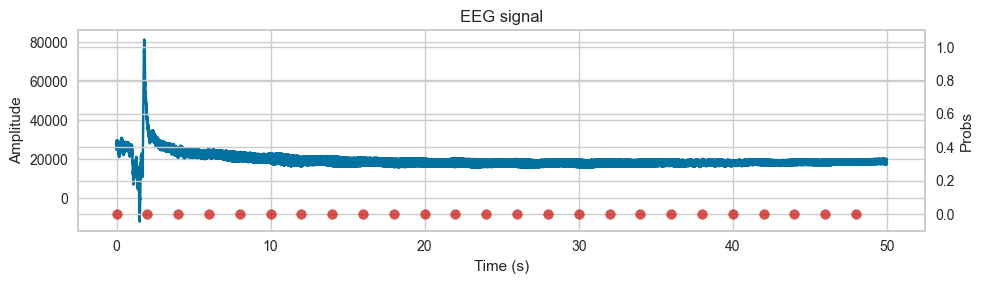

In [258]:
# We first plot the data and target from the first recording
# We see that there is a big DC component
target = np.load(ROOT_PATH + "/target_1.npy")
data = np.load(ROOT_PATH + "/data_1.npy")

print(np.mean(target))

plot_predictions_and_signal(
    target,
    data,
    start_time=300,
    stop_time=350,
    channel_to_plot=1,
)

To remove the DC component and high frequency component we apply a band-pass filter


# 3. Data Filtering


In [259]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="band")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

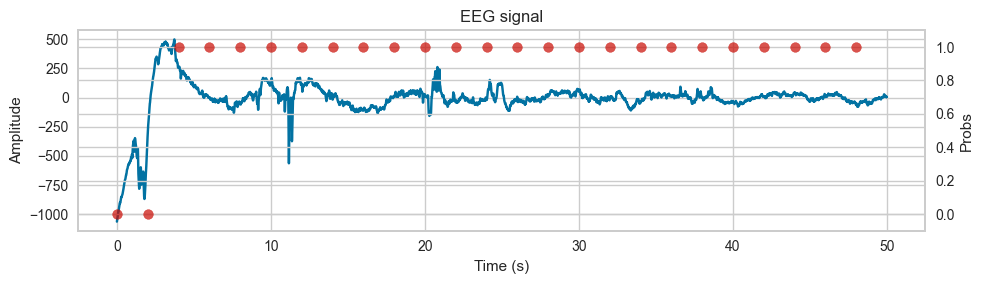

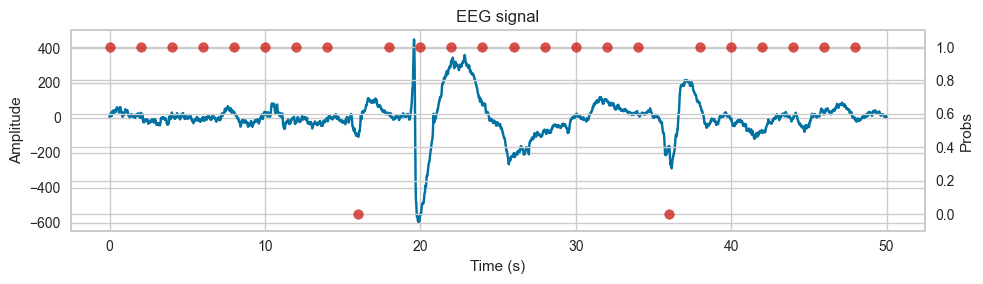

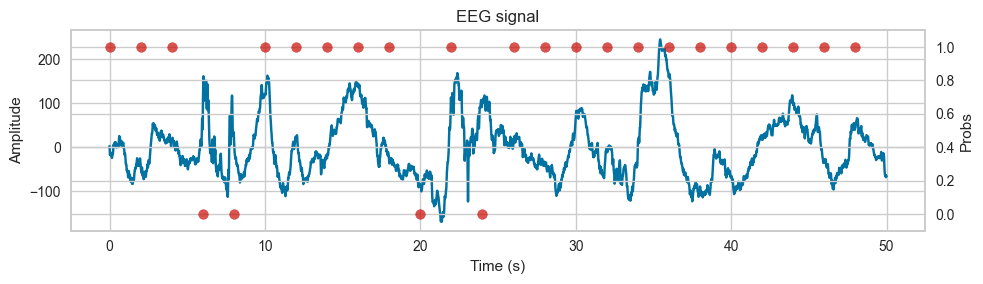

In [260]:
filtered_data = butter_bandpass_filter(data, 0.1, 18, 250, 4)
# We plot three spans and associated labels from the recording

plot_predictions_and_signal(
    target,
    filtered_data,
    start_time=300,
    stop_time=350,
    channel_to_plot=2,
)
plot_predictions_and_signal(
    target,
    filtered_data,
    start_time=350,
    stop_time=400,
    channel_to_plot=2,
)
plot_predictions_and_signal(
    target,
    filtered_data,
    start_time=400,
    stop_time=450,
    channel_to_plot=2,
)

We see that some of the high amplitude is classified as bad quality, we could use that to build a first simple model


## 3.1 Reshape the data by windowing


In [261]:
# First we need to get the point that maps to a label


def reshape_array_into_windows(x, sample_rate, window_duration_in_seconds):
    """
    Reshape the data into an array of shape (C, T, window) where 'window' contains
    the points corresponding to 'window_duration' seconds of data.

    Parameters:
    x (numpy array): The input data array.
    sample_rate (int): The number of samples per second.
    window_duration_in_seconds (float): The duration of each window in seconds.

    Returns:
    reshaped_x (numpy array): The reshaped array with shape (C, T, window).
    """
    # Calculate the number of samples in one window
    window_size = int(window_duration_in_seconds * sample_rate)

    # Ensure the total length of x is a multiple of window_size
    total_samples = x.shape[-1]
    if total_samples % window_size != 0:
        # Truncate or pad x to make it divisible by window_size
        x = x[..., : total_samples - (total_samples % window_size)]
    # Reshape x into (C, T, window)
    reshaped_x = x.reshape(x.shape[0], -1, window_size)

    return reshaped_x

In [262]:
reshaped_array = reshape_array_into_windows(filtered_data, 250, 2)
assert np.array_equal(reshaped_array[0, 0], filtered_data[0, :500])  # Quick unit
print("Initial Data Shape : ", data.shape)
print("Reshaped Array Shape : ", reshaped_array.shape)

Initial Data Shape :  (5, 5232364)
Reshaped Array Shape :  (5, 10464, 500)


`reshaped_array` is now a 3D array with `(channel_of_EEG, number of windows, window_size)`
We will calculate the mean and standard deviation of the EEG for each channel and window and then reshape have a unidimension format `(number of windows)` because we want a dataset in the format `(window_i_j, features)` where `i` is the channel and `j` is the window


## 3.2 Gather Data from all the files


In [263]:
all_data = []
all_targets = []
all_channel_indices = []

# Iterate over the data
for data, target in training_data:
    # Shapes: data, target -> (5, 7712740), (5, 15425)
    filtered_data = butter_bandpass_filter(data, 0.1, 18, 250, 4)  # Shape: (5, 7712740)
    windowed_data = reshape_array_into_windows(
        filtered_data, 250, 2
    )  # Shape: (5, 15425, 500)
    targets_flatten = target[..., : windowed_data.shape[1]].reshape(
        -1
    )  # Shape: (77125,)

    # Reshape data and track channel indices
    flattened_data = windowed_data.reshape(
        (-1, windowed_data.shape[-1])
    )  # Shape: (77125, 500)
    num_samples_per_channel = windowed_data.shape[1]
    channel_indices = np.repeat(
        np.arange(data.shape[0]), num_samples_per_channel
    )  # Shape: (77125,)

    # Append to the lists
    all_data.append(flattened_data)
    all_targets.append(targets_flatten)
    all_channel_indices.append(channel_indices)

# Concatenate all data, targets, and channel indices
all_data = np.concatenate(all_data)
all_targets = np.concatenate(all_targets)
all_channel_indices = np.concatenate(all_channel_indices)

assert all_data.shape[0] == all_targets.shape[0] == all_channel_indices.shape[0]

`all_data` contains all the training data with shape `(number of windows, window_size)` and `all_labels` contains the labels with shape `(number of windows)`. All EEG were concatenated.
\
\
Note : One butterworth filter was applied to all the EEG data


# 4. Feature creation


In [264]:
# This will be our dataframe where we will progressively add features calculated from all_data
df = pd.DataFrame({"target": all_targets, "channel": all_channel_indices})

## 4.1 Statistical Features


### Amplitude


In [265]:
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude = (np.max(all_data, -1) - np.min(all_data, -1)).reshape(-1)
df["log_amplitude"] = np.log(amplitude + 1)

<Axes: xlabel='log_amplitude'>

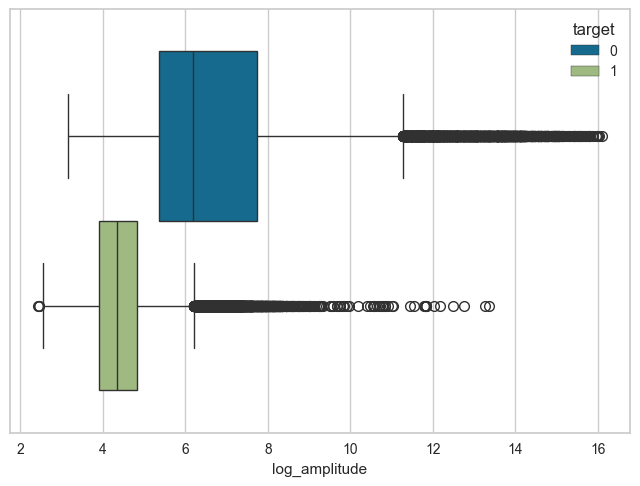

In [266]:
sns.boxplot(df, x="log_amplitude", hue="target")

### Mean


In [267]:
mean = np.mean(all_data, -1).reshape(-1)
rescaled_mean = mean + abs(mean.min())
df["mean"] = mean

<Axes: xlabel='mean'>

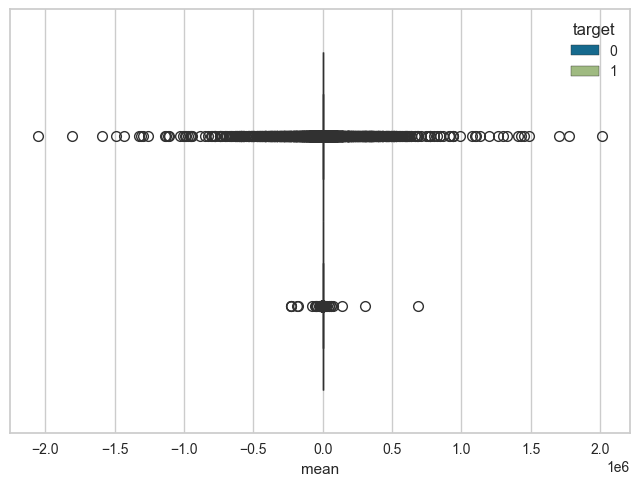

In [268]:
sns.boxplot(df, x="mean", hue="target")

### Min and Max


In [269]:
min = np.min(all_data, -1).reshape(-1)
max = np.max(all_data, -1).reshape(-1)
df["min"] = min
df["max"] = max

<Axes: xlabel='max'>

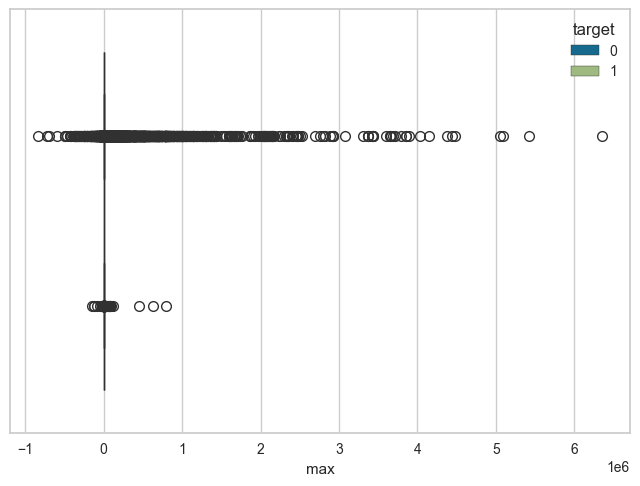

In [270]:
sns.boxplot(df, x="max", hue="target")

### Standard Deviation


In [271]:
std = (np.std(all_data, axis=-1)).reshape(-1)
df["log_std"] = np.log(std + 1)

<Axes: xlabel='log_std'>

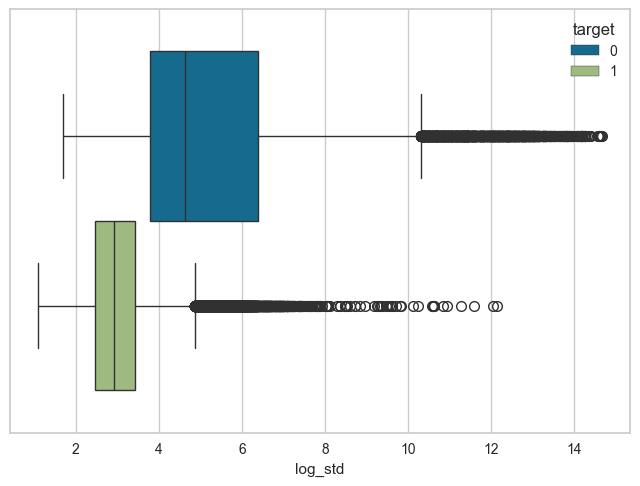

In [272]:
sns.boxplot(df, x="log_std", hue="target")

### Skew


In [273]:
from scipy.stats import skew

skewness = (skew(all_data, axis=-1)).reshape(-1)
df["skewness"] = skewness

<Axes: xlabel='skewness'>

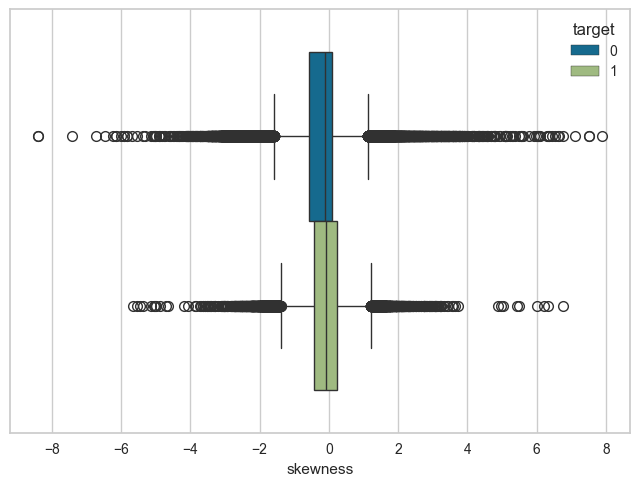

In [274]:
sns.boxplot(df, x="skewness", hue="target")

### Kurtosis


In [275]:
from scipy.stats import kurtosis

kurt = (kurtosis(all_data, axis=-1)).reshape(-1)
df["log_kurtosis"] = np.log(kurt + np.abs(np.min(kurt)) + 1)

<Axes: xlabel='log_kurtosis'>

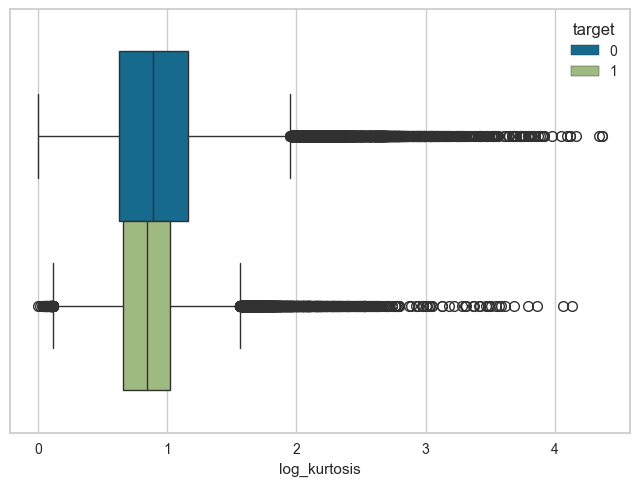

In [276]:
sns.boxplot(df, x="log_kurtosis", hue="target")

### MMD (Min Max Distance)


In [277]:
idx_diff_between_max_and_min = (
    np.argmax(all_data, axis=-1) - np.argmin(all_data, axis=-1)
).reshape(-1)
amplitude = (np.max(all_data, -1) - np.min(all_data, -1)).reshape(-1)
MMD = idx_diff_between_max_and_min**2 + amplitude**2
df["log_MMD"] = np.log(MMD + 1)

<Axes: xlabel='log_MMD'>

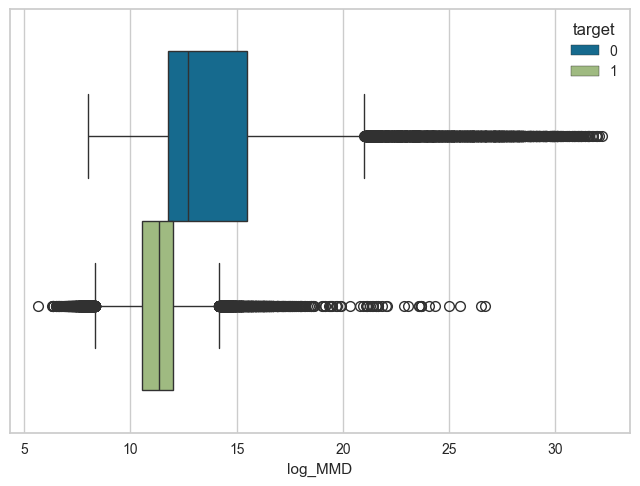

In [278]:
sns.boxplot(df, x="log_MMD", hue="target")

## 4.2 Frequency Features


### Energy of the signal


In [279]:
# Calculate energy of signal
energy = (np.sum(all_data**2, axis=-1)).reshape(-1)
df["log_energy"] = np.log(energy + 1)

<Axes: xlabel='log_energy'>

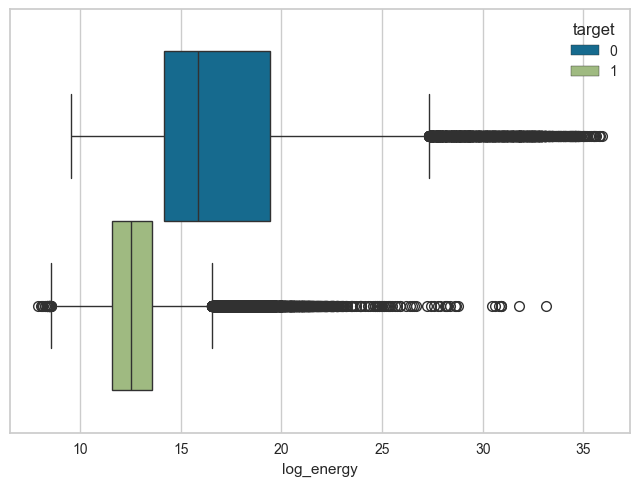

In [280]:
sns.boxplot(df, x="log_energy", hue="target")

### Dominant frequency


In [281]:
# calculate the dominant frequency
from scipy import fftpack


def dominant_frequency(x):
    N = x.size // 2
    freq = fftpack.fftfreq(x.size, d=1 / 250)[:N]
    fft = fftpack.fft(x)[:N]
    amp = np.abs(fft)
    order = np.argsort(amp)[::-1]
    return freq[order[0]]


dom_freq = np.apply_along_axis(dominant_frequency, -1, all_data)
df["log_dominant_freq"] = np.log(dom_freq + 1)

<Axes: xlabel='log_dominant_freq'>

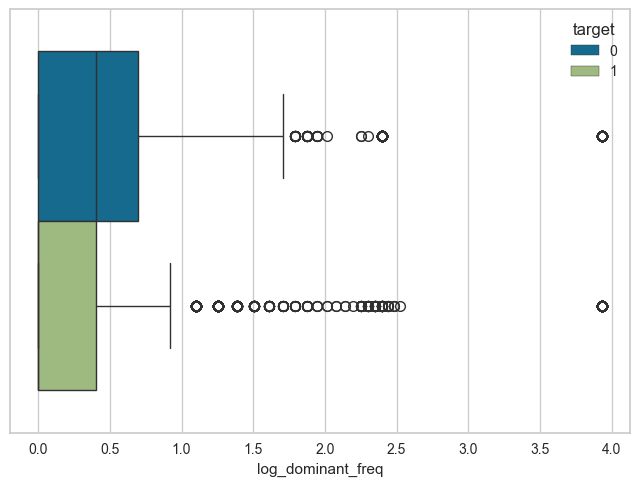

In [282]:
sns.boxplot(df, x="log_dominant_freq", hue="target")

### Spectral Entropy


In [283]:
# Calculate the spectral entropy of each window
from scipy.signal import periodogram, welch


def spectral_entropy(x):
    # Step 1 : calculate the power spectral density
    f, Pxx = welch(x, fs=250)
    # Step 2 : normalize the power spectral density
    Pxx_norm = Pxx / Pxx.sum()
    # Step 3 : calculate the spectral entropy
    return np.nansum(-(Pxx_norm * np.log2(Pxx_norm)))


spec_entropy = np.apply_along_axis(spectral_entropy, -1, all_data)
df["spec_entropy"] = spec_entropy

<Axes: xlabel='spec_entropy'>

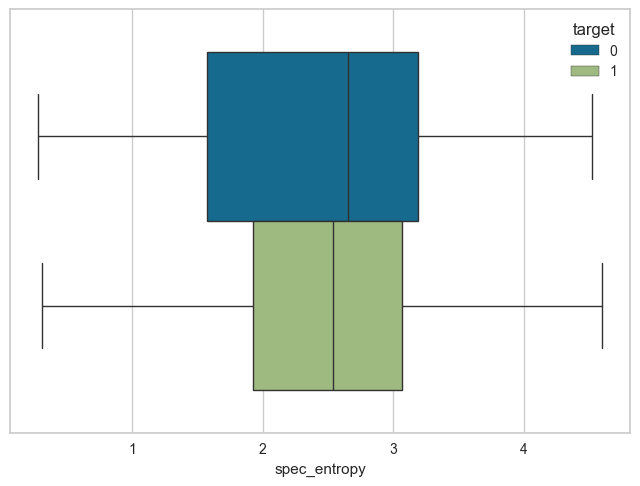

In [284]:
sns.boxplot(df, x="spec_entropy", hue="target")

### Esis


### Energy for different frequency bands


In [343]:
# Calculate the energy for each frequency band


def energy_in_frequency_band(x):
    frequency = 250
    n_bins = 100
    n_samples = x.size
    freq_bins = np.linspace(0, frequency / 2, n_bins)
    out = {}
    freqs = np.fft.fftfreq(x.size, d=1 / 250)
    fourier = abs(fftpack.fft(x))
    for f_min, f_max in zip(freq_bins[:-1], freq_bins[1:]):
        band = (f_min < freqs) & (freqs <= f_max)
        energy = np.sum(fourier[band] ** 2)
        out[f"energy_{f_min:.0f}-{f_max:.0f}"] = energy
    return out


arr_energy_ber_band = np.apply_along_axis(energy_in_frequency_band, -1, all_data)

In [344]:
keys = arr_energy_ber_band[0].keys()
dic_energy_per_band = {}
for k in keys:
    concat = []
    for signal in arr_energy_ber_band:
        concat.append(signal[k])
    dic_energy_per_band[k] = concat

In [349]:
df_energy_per_band = pd.DataFrame(dic_energy_per_band)
if df.columns[df.columns.str.contains("energy_")].empty:
    df = pd.concat([df, df_energy_per_band], axis=1)

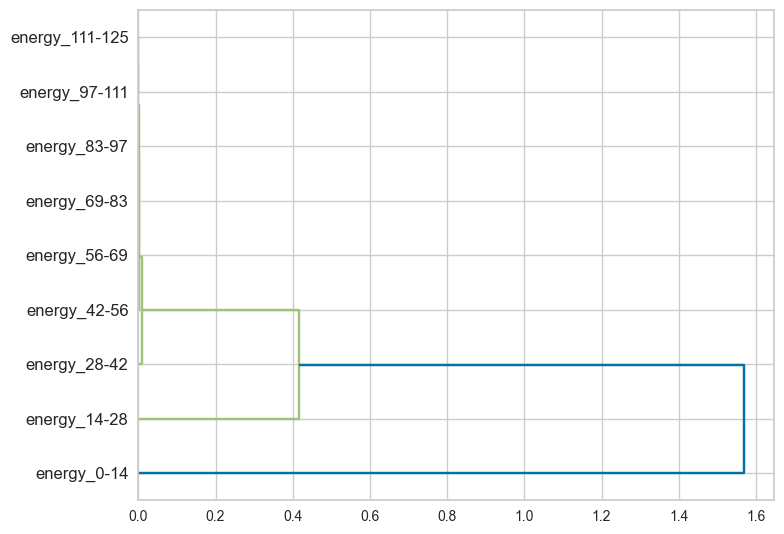

In [350]:
# Perform dendrogram clustering
from scipy.cluster.hierarchy import linkage, dendrogram, average, fcluster
from scipy.spatial.distance import pdist

energy_cols = df.columns[df.columns.str.contains("energy_")]
corr = df[energy_cols].corr()
distance_metric = np.abs(corr)
linkage_matrix = linkage(distance_metric, method="ward")
dendrogram(linkage_matrix, labels=energy_cols, orientation="right")
plt.tight_layout()
plt.show()

In [351]:
threshold = 0.5  # Adjust this value based on your needs
clusters = fcluster(linkage_matrix, t=threshold, criterion="distance")
# Print cluster assignments
cluster_assignments = dict(zip(energy_cols, clusters))
print("Cluster Assignments:", cluster_assignments)

# Retain only the first feature per cluster
selected_features = []
seen_clusters = set()
for feature, cluster in cluster_assignments.items():
    if cluster not in seen_clusters:
        selected_features.append(feature)
        seen_clusters.add(cluster)

print("Selected Features:", selected_features)

Cluster Assignments: {'energy_0-14': 2, 'energy_14-28': 1, 'energy_28-42': 1, 'energy_42-56': 1, 'energy_56-69': 1, 'energy_69-83': 1, 'energy_83-97': 1, 'energy_97-111': 1, 'energy_111-125': 1}
Selected Features: ['energy_0-14', 'energy_14-28']


In [291]:
energy_cols_to_drop = energy_cols.difference(selected_features)
# df = df.drop(columns=energy_cols_to_drop)

## 4.3 Temporal Features


### Linear Trend


In [292]:
# Add linear trend of the window
from scipy.stats import linregress

linear_trend = np.apply_along_axis(
    lambda x: linregress(np.arange(len(x)), x).slope, -1, all_data
).reshape(-1)
df["linear_trend"] = linear_trend

<Axes: xlabel='linear_trend'>

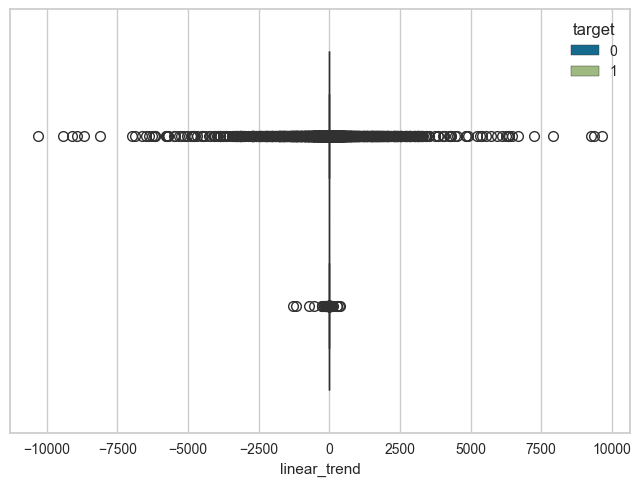

In [293]:
sns.boxplot(df, x="linear_trend", hue="target")

### Autocorrelation of the signal


In [294]:
# Add autocorrelation of each window

from scipy.signal import correlate

### Number of zero crossings


In [295]:
# Calculate the number of zero crossings for each window
def zero_crossings(x):
    return np.sum(np.diff(np.sign(x)) != 0)


zero_cross = np.apply_along_axis(zero_crossings, -1, all_data).reshape(-1)
df["zero_crossing"] = zero_cross

<Axes: xlabel='zero_crossing'>

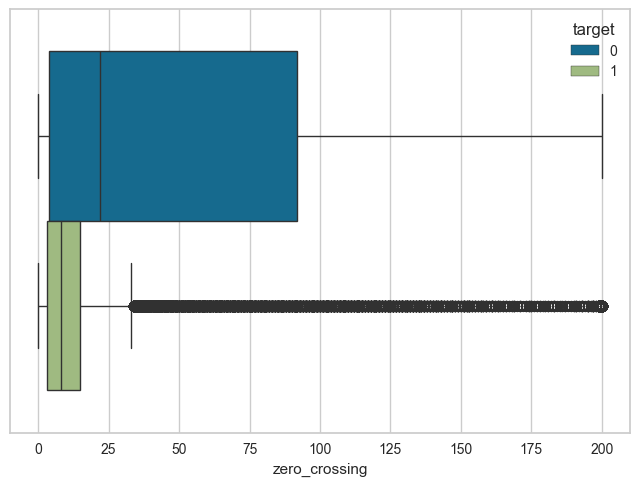

In [296]:
sns.boxplot(df, x="zero_crossing", hue="target")

### Number of peaks


In [297]:
# Count the number of peaks in each window
from scipy.signal import find_peaks


def count_peaks(x):
    return len(find_peaks(x)[0])


peaks = np.apply_along_axis(count_peaks, -1, all_data).reshape(-1)
df["number_peak"] = peaks

<Axes: xlabel='number_peak'>

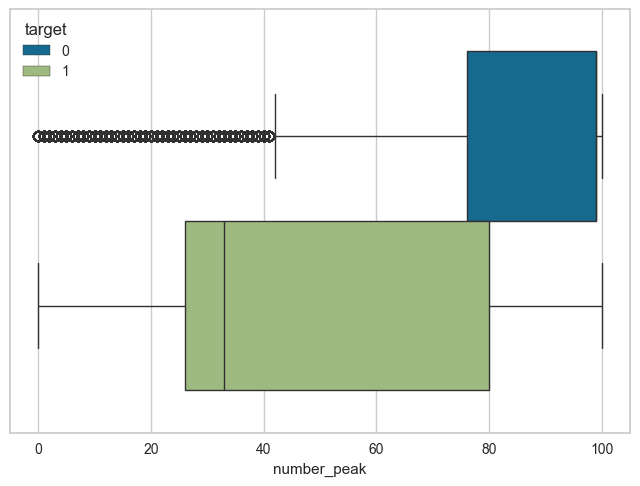

In [298]:
sns.boxplot(df, x="number_peak", hue="target")

### Max Peak prominence


In [299]:
from scipy.signal import peak_prominences


def max_peak_prominence(x):
    peaks, _ = find_peaks(x)
    if len(peaks) == 0:
        return 0
    prominences = peak_prominences(x, peaks)[0]
    return np.max(prominences)


max_peak_prom = np.apply_along_axis(max_peak_prominence, -1, all_data).reshape(-1)
df["log_max_peak_prominence"] = np.log(max_peak_prom + 1)

<Axes: xlabel='log_max_peak_prominence'>

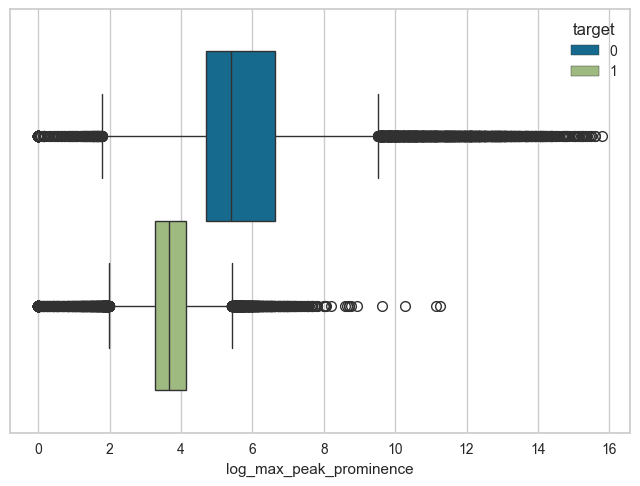

In [300]:
sns.boxplot(df, x="log_max_peak_prominence", hue="target")

### Max Peak width


In [301]:
from scipy.signal import peak_widths


def max_peak_width(x):
    peaks, _ = find_peaks(x)
    if len(peaks) == 0:
        return 0
    widths = peak_widths(x, peaks)[0]
    return np.max(widths)


max_peak_widths = np.apply_along_axis(max_peak_width, -1, all_data).reshape(-1)
df["max_peak_width"] = max_peak_widths

<Axes: xlabel='max_peak_width'>

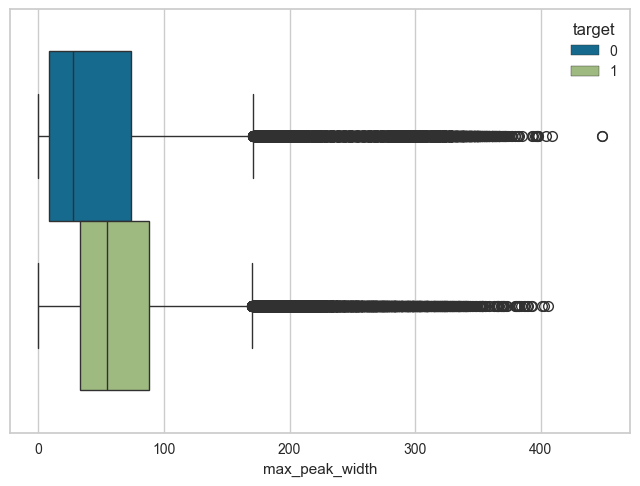

In [302]:
sns.boxplot(df, x="max_peak_width", hue="target")

### Mean and Var of peak amplitude


In [303]:
def mean_of_peaks(x):
    peaks, _ = find_peaks(x)
    if len(peaks) == 0:
        return 0
    return np.mean(abs(x[peaks]))


def var_of_peaks(x):
    peaks, _ = find_peaks(x)
    if len(peaks) == 0:
        return 0
    return np.var(x[peaks])


mean_peaks = np.apply_along_axis(mean_of_peaks, -1, all_data).reshape(-1)
df["mean_peak"] = mean_peaks
var_peaks = np.apply_along_axis(var_of_peaks, -1, all_data).reshape(-1)
df["var_peak"] = var_peaks

### Derivatives features


In [304]:
def mean_1st_derivative(x):
    return np.mean(np.diff(x))


def var_1st_derivative(x):
    return np.var(np.diff(x))


def mean_2nd_derivative(x):
    return np.mean(np.diff(np.diff(x)))


def var_2nd_derivative(x):
    return np.var(np.diff(np.diff(x)))


mean_1st_der = np.apply_along_axis(mean_1st_derivative, -1, all_data).reshape(-1)
df["mean_1st_derivative"] = mean_1st_der
var_1st_der = np.apply_along_axis(var_1st_derivative, -1, all_data).reshape(-1)
df["var_1st_derivative"] = var_1st_der
mean_2nd_der = np.apply_along_axis(mean_2nd_derivative, -1, all_data).reshape(-1)
df["mean_2nd_derivative"] = mean_2nd_der
var_2nd_der = np.apply_along_axis(var_2nd_derivative, -1, all_data).reshape(-1)
df["var_2nd_derivative"] = var_2nd_der

### Change point detection


## 4.4 Reconstruction features


### SSA (Singular Spectrum Analysis)


# EDA & Data Quality Check


In [352]:
df.isna().sum()

target                     0
channel                    0
log_amplitude              0
mean                       0
min                        0
max                        0
log_std                    0
skewness                   0
log_kurtosis               0
log_MMD                    0
log_energy                 0
log_dominant_freq          0
spec_entropy               0
linear_trend               0
zero_crossing              0
number_peak                0
log_max_peak_prominence    0
max_peak_width             0
mean_peak                  0
var_peak                   0
mean_1st_derivative        0
var_1st_derivative         0
mean_2nd_derivative        0
var_2nd_derivative         0
energy_0-14                0
energy_14-28               0
energy_28-42               0
energy_42-56               0
energy_56-69               0
energy_69-83               0
energy_83-97               0
energy_97-111              0
energy_111-125             0
dtype: int64

# Feature selection


# Train test split


We need to split our data into train and test. However. we need to be careful on how we split because :

- If window `i` is in the training set and window `i+1` is in the test set, we will have data leakage because we can expect that the quality of the EEG is correlated between two consecutive windows.
- Our data is not balanced, we need to make sure that the train and test set have the same proportion of good and bad quality EEG.

We will :

- Shuffle the data to remove the data leakage
- Stratify the data to keep the same proportion of good and bad quality EEG in the train and test set


In [353]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

df_shuffled = df.sample(frac=1, random_state=42)
X = df_shuffled.drop("target", axis=1)
y = df_shuffled["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=X["channel"], random_state=42
)

# Baseline models


The goal is to build a simple model that can be used as a baseline. We will use a logistic regression and a random forest.


In [307]:
from pycaret.classification import ClassificationExperiment

In [308]:
s = ClassificationExperiment()
s.setup(df_shuffled, target="target", session_id=123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(261755, 48)"
4,Transformed data shape,"(261755, 48)"
5,Transformed train set shape,"(183228, 48)"
6,Transformed test set shape,"(78527, 48)"
7,Numeric features,47
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# best = s.compare_models(include=["catboost", "rf", "lightgbm", "xgboost", "et"])

In [ ]:
# s.evaluate_model(best)

<Figure size 800x550 with 0 Axes>

# Selected Model


In [354]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

pipeline = Pipeline(
    [("scaler", StandardScaler()), ("model", CatBoostClassifier(verbose=0))]
)
pipeline.fit(X, y)
pred_test = pipeline.predict(X_test)
pred_train = pipeline.predict(X_train)

We can now evaluate the cohen kappa


In [355]:
from sklearn.metrics import cohen_kappa_score, f1_score

print("TRAIN (Kappa) :", cohen_kappa_score(pred_train, y_train))
print("TRAIN (f1) :", f1_score(pred_train, y_train))
print("TEST (Kappa) :", cohen_kappa_score(pred_test, y_test))
print("TEST (f1) :", f1_score(pred_test, y_test))

TRAIN (Kappa) : 0.9321559048192541
TRAIN (f1) : 0.9726597182783141
TEST (Kappa) : 0.9332265428900064
TEST (f1) : 0.9731903485254692


# Hyperparameter tuning with Cross-Validation and Optuna


Key points for cross validation:

- StratifyKFold


In [312]:
import optuna


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        # 'random_strength': trial.suggest_int('random_strength', 1, 100),
        # 'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        # 'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        # 'od_wait': trial.suggest_int('od_wait', 10, 50),
        "cat_features": ["channel"],
        "verbose": 0,
    }
    model = CatBoostClassifier(**params)
    model.fit(X, y)
    pred = model.predict(X_test)
    return cohen_kappa_score(pred, y_test)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Running the model on the test data and submitting to the leaderboard


In [356]:
ROOT_TEST_PATH = "test/"
test_data = {i: np.load(ROOT_TEST_PATH + f"data_{i}.npy") for i in [4, 5]}
# We process each record independantly


def compute_features_on_record(data):
    """
    We compute each of the feature for each window and each channel
    Each value of the output dict has shape (Channels,T)
    """
    filtered_data = butter_bandpass_filter(data, 0.1, 18, 250, 4)
    reshaped_data = reshape_array_into_windows(filtered_data, 250, 2)
    amplitude = np.max(reshaped_data, -1) - np.min(reshaped_data, -1)
    log_amplitude = np.log(amplitude + 1)
    mean = np.mean(reshaped_data, -1)
    rescaled_mean = mean + abs(mean.min())
    std = np.std(reshaped_data, axis=-1)
    log_std = np.log(std + 1)
    skewness = skew(reshaped_data, axis=-1)
    kurt = kurtosis(reshaped_data, axis=-1)
    log_kurtosis = np.log(kurt + np.abs(np.min(kurt)) + 1)
    min = np.min(reshaped_data, -1)
    max = np.max(reshaped_data, -1)
    idx_diff_between_max_and_min = np.argmax(reshaped_data, axis=-1) - np.argmin(
        reshaped_data, axis=-1
    )
    mmd = idx_diff_between_max_and_min**2 + amplitude**2
    log_mmd = np.log(1 + mmd)
    energy = np.sum(reshaped_data**2, axis=-1)
    log_energy = np.log(1 + energy)
    dom_freq = np.apply_along_axis(dominant_frequency, -1, reshaped_data)
    log_dom_freq = np.log(1 + dom_freq)
    spec_entropy = np.apply_along_axis(spectral_entropy, -1, reshaped_data)
    # Energy
    flattened_data = reshaped_data.reshape((-1, reshaped_data.shape[-1]))
    energy_in_freq_band = np.apply_along_axis(
        energy_in_frequency_band, -1, flattened_data
    )
    keys = energy_in_freq_band[0].keys()
    dic_energy_per_band = {}
    for k in keys:
        concat = []
        for signal in energy_in_freq_band:
            concat.append(signal[k])
        dic_energy_per_band[k] = concat

    df_energy_per_band = pd.DataFrame(dic_energy_per_band)
    arr_energy = df_energy_per_band.to_numpy()
    arr_energy = arr_energy.reshape(5, -1, arr_energy.shape[1])
    dic_energy_final = {
        feat_name: arr_energy[:, :, i] for i, feat_name in enumerate(keys)
    }
    # Linear Trend
    linear_trend = np.apply_along_axis(
        lambda x: linregress(np.arange(len(x)), x).slope, -1, reshaped_data
    )
    zero_cross = np.apply_along_axis(zero_crossings, -1, reshaped_data)
    nb_peaks = np.apply_along_axis(count_peaks, -1, reshaped_data)
    max_peak_prom = np.apply_along_axis(max_peak_prominence, -1, reshaped_data)
    log_max_peak_prom = np.log(max_peak_prom + 1)
    max_peak_wid = np.apply_along_axis(max_peak_width, -1, reshaped_data)
    mean_peaks = np.apply_along_axis(mean_of_peaks, -1, reshaped_data)
    var_peaks = np.apply_along_axis(var_of_peaks, -1, reshaped_data)
    mean_1st_der = np.apply_along_axis(mean_1st_derivative, -1, reshaped_data)
    var_1st_der = np.apply_along_axis(var_1st_derivative, -1, reshaped_data)
    mean_2nd_der = np.apply_along_axis(mean_2nd_derivative, -1, reshaped_data)
    var_2nd_der = np.apply_along_axis(var_2nd_derivative, -1, reshaped_data)
    out = {
        "log_amplitude": log_amplitude,
        "log_std": log_std,
        "mean": rescaled_mean,
        "skewness": skewness,
        "log_kurtosis": log_kurtosis,
        "min": min,
        "max": max,
        "log_MMD": log_mmd,
        "log_energy": log_energy,
        "log_dominant_freq": log_dom_freq,
        "spec_entropy": spec_entropy,
        "linear_trend": linear_trend,
        "zero_crossing": zero_cross,
        "number_peak": nb_peaks,
        "log_max_peak_prominence": log_max_peak_prom,
        "max_peak_width": max_peak_wid,
        "mean_peak": mean_peaks,
        "var_peak": var_peaks,
        "mean_1st_derivative": mean_1st_der,
        "var_1st_derivative": var_1st_der,
        "mean_2nd_derivative": mean_2nd_der,
        "var_2nd_derivative": var_2nd_der,
    }
    out.update(dic_energy_final)
    return out


def compute_predictions_on_record(data, model, features_name_for_model):
    predictions = []
    features = compute_features_on_record(data)
    feature_names = list(features.keys())
    features = np.array([features[k] for k in feature_names])
    features = features.swapaxes(0, 1).swapaxes(1, 2)
    for channel in range(features.shape[0]):
        X_pred = pd.DataFrame(features[channel], columns=feature_names)
        X_pred["channel"] = channel
        # Re-arrange order like in training
        X_pred = X_pred[X_train.columns]
        preds = model.predict(X_pred)
        predictions.append(preds)
    return np.array(predictions)


def format_array_to_target_format(array, record_number):
    assert isinstance(record_number, int)
    assert isinstance(array, np.ndarray)
    assert len(array.shape) == 2
    assert array.shape[0] == 5
    assert set(np.unique(array)) == {0, 1}
    formatted_target = []
    for i in range(array.shape[0]):
        channel_encoding = (i + 1) * 100000
        record_number_encoding = record_number * 1000000
        for j in range(array.shape[1]):
            formatted_target.append(
                {
                    "identifier": record_number_encoding + channel_encoding + j,
                    "target": array[i, j],
                }
            )
    return formatted_target

We the functions defined above, we can now run the model and submit the predictions


In [357]:
results = []
features_name_for_model = "changed the func to select all the features"
final_model = pipeline
for record_number, data in test_data.items():
    preds = compute_predictions_on_record(data, final_model, features_name_for_model)
    formatted_preds = format_array_to_target_format(preds, record_number)
    results.extend(formatted_preds)
results = pd.DataFrame(results)
results.to_csv("submission.csv", index=False)